**In this study we investigated the use of financial analysis techniques for fraud detection. We first used the Jones model and the Modified Jones model to determine if firms that issue financial restatements tend to have higher discretionary accruals than firms that do not issue financial restatements. Moreover, we explored other attributes that may predict fraud and used a logistic regression model to predict fraudulent firms based on their financial data. Finally, we verify our fraud prediction with 2018 restatement data.**

In [1]:
! pip install wrds

     |████████████████████████████████| 2.9MB 7.3MB/s 


In [2]:
import wrds
conn = wrds.Connection(wrds_username='szfy')

Enter your WRDS username [root]:szfy
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [0]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats
import matplotlib.pyplot as plt
import statistics

## **Table joining and Data Preprocessing**

**Audit data**

In [0]:

audit = conn.raw_sql("""
                      select company_fkey, matchfy_date_qtr, priorfy_date_qtr, res_cler_err, res_accounting, res_fraud, best_edgar_ticker
	                  from audit.auditnonreli
                      """) 

In [5]:
audit.head()

,company_fkey,matchfy_date_qtr,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker
0,0000001750,2016-05-31,2015-05-31,0.0,1.0,0.0,AIR
1,0000001853,2006-12-28,2005-12-31,0.0,1.0,0.0,None
2,0000001853,2007-12-28,2006-12-28,0.0,1.0,0.0,None
3,0000001923,2009-04-30,2008-04-30,0.0,1.0,0.0,None
4,0000002034,None,2018-06-30,0.0,1.0,0.0,None


In [6]:
## check if 1.0 can exist in more than 1 column for each record
audit[(audit['res_accounting']==1) & (audit['res_fraud']==1)]

,company_fkey,matchfy_date_qtr,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker
90,0000005272,2005-12-31,2004-12-31,0.0,1.0,1.0,AIG
91,0000077155,None,2002-02-02,0.0,1.0,1.0,None
159,0000008328,2007-12-31,2006-12-31,0.0,1.0,1.0,AMNL
209,0000010427,2005-12-31,2004-12-25,0.0,1.0,1.0,None
283,0000015615,2004-12-31,2003-12-31,0.0,1.0,1.0,MTZ
...,...,...,...,...,...,...,...
16606,0001450390,2016-12-31,2015-12-31,0.0,1.0,1.0,None
16697,0001460329,2010-12-31,2009-12-31,0.0,1.0,1.0,FLNT
16813,0001473061,2009-12-31,2008-12-31,0.0,1.0,1.0,PSTRQ
17603,0001547996,2014-12-31,2013-12-31,0.0,1.0,1.0,NGBL


**ipo data**

In [0]:
ipo = conn.raw_sql("""
                      select company_fkey, matchfy_date_qtr, ipo_price, ipo_shares
	                  from audit.ipo
                      """) 

In [8]:
ipo.head()

,company_fkey,matchfy_date_qtr,ipo_price,ipo_shares
0,0000001750,None,0.0,0.0
1,0000001800,None,0.0,0.0
2,0000002034,None,0.0,0.0
3,0000002135,None,0.0,0.0
4,0000002186,None,37.5,0.0


**fundamental annual**

In [0]:
funda = conn.raw_sql("""
                      select gvkey, fyear, act, oiadp, at, che, lct, dlc, txp, dp, exchg, datadate, tic, cik, ppent, revt, rect
	                  from compa.funda where (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and 
	                     fyear>2008 and
                       fyear<2016 
                      """) 

In [10]:
funda=funda.rename(columns={'cik':'company_fkey','datadate':'matchfy_date_qtr'})
funda.head()

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect
0,001004,2009.0,863.429,95.415,1501.042,79.370,325.550,100.833,3.263,38.930,11.0,2010-05-31,AIR,0000001750,334.430,1352.151,238.466
1,001004,2010.0,913.985,137.016,1703.727,57.433,416.010,114.075,0.000,59.296,11.0,2011-05-31,AIR,0000001750,417.764,1775.782,296.489
2,001004,2011.0,1063.272,142.360,2195.653,67.720,473.226,122.865,0.000,80.333,11.0,2012-05-31,AIR,0000001750,456.015,2074.498,324.879
3,001004,2012.0,1033.700,136.600,2136.900,75.300,389.000,86.400,0.000,108.600,11.0,2013-05-31,AIR,0000001750,426.400,2167.100,315.400
4,001004,2013.0,1116.900,142.600,2199.500,89.200,402.100,69.700,0.000,113.400,11.0,2014-05-31,AIR,0000001750,413.300,2035.000,297.900


In [11]:
funda.shape

(80232, 17)

In [0]:
## accrual variable construction

In [13]:
# lag1 variables
funda1=funda[['gvkey', 'fyear', 'act', 'at', 'che', 'lct', 'dlc', 'txp','revt','rect','ppent']].copy()
funda1['fyear']=funda1['fyear']+1 
funda1=funda1.rename(columns={'at':'at_lag1', 'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1','txp':'txp_lag1','revt':'revt_lag1','rect':'rect_lag1','ppent':'ppent_lag1'})
funda1=pd.merge(funda,funda1,how='left',on=['gvkey','fyear'])
funda1=funda1.dropna()
funda1

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1
1,001004,2010.0,913.985,137.016,1703.727,57.433,416.010,114.075,0.000,59.296,11.0,2011-05-31,AIR,0000001750,417.764,1775.782,296.489,863.429,1501.042,79.370,325.550,100.833,3.263,1352.151,238.466,334.430
2,001004,2011.0,1063.272,142.360,2195.653,67.720,473.226,122.865,0.000,80.333,11.0,2012-05-31,AIR,0000001750,456.015,2074.498,324.879,913.985,1703.727,57.433,416.010,114.075,0.000,1775.782,296.489,417.764
3,001004,2012.0,1033.700,136.600,2136.900,75.300,389.000,86.400,0.000,108.600,11.0,2013-05-31,AIR,0000001750,426.400,2167.100,315.400,1063.272,2195.653,67.720,473.226,122.865,0.000,2074.498,324.879,456.015
4,001004,2013.0,1116.900,142.600,2199.500,89.200,402.100,69.700,0.000,113.400,11.0,2014-05-31,AIR,0000001750,413.300,2035.000,297.900,1033.700,2136.900,75.300,389.000,86.400,0.000,2167.100,315.400,426.400
5,001004,2014.0,954.100,-8.600,1515.000,54.700,412.000,69.000,0.000,92.300,11.0,2015-05-31,AIR,0000001750,295.000,1594.300,231.100,1116.900,2199.500,89.200,402.100,69.700,0.000,2035.000,297.900,413.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80216,318815,2014.0,49.269,-12.018,78.776,47.240,4.412,0.765,0.000,0.502,14.0,2014-12-31,MTP,0001643918,2.362,0.245,1.953,6.787,8.575,3.956,3.803,2.068,0.000,0.244,2.718,1.134
80217,318815,2015.0,29.980,-14.881,94.435,23.852,13.417,0.651,0.000,1.087,14.0,2015-12-31,MTP,0001643918,2.925,2.028,4.441,49.269,78.776,47.240,4.412,0.765,0.000,0.245,1.953,2.362
80219,318970,2013.0,8.788,-2.027,34.121,3.556,4.959,0.000,0.241,4.276,19.0,2013-12-31,NXXYF,0001645209,0.320,18.705,3.981,3.465,29.155,0.793,3.249,0.000,0.306,12.238,1.941,0.357
80220,318970,2014.0,40.292,0.616,68.397,28.099,18.140,1.120,1.240,4.798,19.0,2014-12-31,NXXYF,0001645209,1.127,27.278,10.543,8.788,34.121,3.556,4.959,0.000,0.241,18.705,3.981,0.320


In [14]:
# Earnings  = Income from Continuing Operations(OIADP) / Average Total Assets
# Average Total Assets = (ATt + ATt-1) / 2
funda1['Avg_Total_Asset']=(funda1['at']+funda1['at_lag1'])/2
funda1['Earning']=funda1['oiadp']/funda1['Avg_Total_Asset']
funda1

# Accrual Component = Accruals / Average Total Assets
# Accruals = (delta(CA)-delta(Cash)) - (delta(CL)-delta(STD)-delta(TP)) - Dep
funda1['CA']=funda1['act']-funda1['act_lag1']
funda1['Cash']=funda1['che']-funda1['che_lag1']
funda1['CL']=funda1['lct']-funda1['lct_lag1']
funda1['STD']=funda1['dlc']-funda1['dlc_lag1']
funda1['TP']=(funda1['txp']+funda1['txp_lag1'])/2
funda1['Accruals']=(funda1['CA']-funda1['Cash'])-(funda1['CL']-funda1['STD']-funda1['TP'])-funda1['dp']
funda1['Accrual_component']=funda1['Accruals']/funda1['Avg_Total_Asset']
funda1

# Cash Flow Component = Earnings - Accrual Component
funda1['CF_component']=funda1['Earning']-funda1['Accrual_component']

## change in ppe during the year 
funda1['ppe'] = (funda1['ppent'] - funda1['ppent_lag1'])/funda1['Avg_Total_Asset']

# delta(revenue)
funda1['delta_rev']=(funda1['revt']-funda1['revt_lag1'])/funda1['Avg_Total_Asset']
# delta(receivable)
funda1['delta_rec']=(funda1['rect']-funda1['rect_lag1'])/funda1['Avg_Total_Asset']
# delta(revenue) - delta(receivable)
funda1['delta_rev_rec'] = funda1['delta_rev'] - funda1['delta_rec']
# ppe adjust for firm size
funda1['ppent'] = funda1['ppent'] / funda1['Avg_Total_Asset']

funda=funda1.dropna()
funda

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,ppe,delta_rev,delta_rec,delta_rev_rec
1,001004,2010.0,913.985,137.016,1703.727,57.433,416.010,114.075,0.000,59.296,11.0,2011-05-31,AIR,0000001750,0.260714,1775.782,296.489,863.429,1501.042,79.370,325.550,100.833,3.263,1352.151,238.466,334.430,1602.3845,0.085508,50.556,-21.937,90.460,13.242,1.6315,-62.3895,-0.038935,0.124443,0.052006,0.264375,0.036210,0.228165
2,001004,2011.0,1063.272,142.360,2195.653,67.720,473.226,122.865,0.000,80.333,11.0,2012-05-31,AIR,0000001750,0.233891,2074.498,324.879,913.985,1703.727,57.433,416.010,114.075,0.000,1775.782,296.489,417.764,1949.6900,0.073017,149.287,10.287,57.216,8.790,0.0000,10.2410,0.005253,0.067764,0.019619,0.153212,0.014561,0.138651
3,001004,2012.0,1033.700,136.600,2136.900,75.300,389.000,86.400,0.000,108.600,11.0,2013-05-31,AIR,0000001750,0.196835,2167.100,315.400,1063.272,2195.653,67.720,473.226,122.865,0.000,2074.498,324.879,456.015,2166.2765,0.063058,-29.572,7.580,-84.226,-36.465,0.0000,-97.9910,-0.045235,0.108292,-0.013671,0.042747,-0.004376,0.047123
4,001004,2013.0,1116.900,142.600,2199.500,89.200,402.100,69.700,0.000,113.400,11.0,2014-05-31,AIR,0000001750,0.190619,2035.000,297.900,1033.700,2136.900,75.300,389.000,86.400,0.000,2167.100,315.400,426.400,2168.2000,0.065769,83.200,13.900,13.100,-16.700,0.0000,-73.9000,-0.034084,0.099852,-0.006042,-0.060926,-0.008071,-0.052855
5,001004,2014.0,954.100,-8.600,1515.000,54.700,412.000,69.000,0.000,92.300,11.0,2015-05-31,AIR,0000001750,0.158837,1594.300,231.100,1116.900,2199.500,89.200,402.100,69.700,0.000,2035.000,297.900,413.300,1857.2500,-0.004631,-162.800,-34.500,9.900,-0.700,0.0000,-231.2000,-0.124485,0.119855,-0.063696,-0.237286,-0.035967,-0.201319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80216,318815,2014.0,49.269,-12.018,78.776,47.240,4.412,0.765,0.000,0.502,14.0,2014-12-31,MTP,0001643918,0.054081,0.245,1.953,6.787,8.575,3.956,3.803,2.068,0.000,0.244,2.718,1.134,43.6755,-0.275166,42.482,43.284,0.609,-1.303,0.0000,-3.2160,-0.073634,-0.201532,0.028116,0.000023,-0.017516,0.017538
80217,318815,2015.0,29.980,-14.881,94.435,23.852,13.417,0.651,0.000,1.087,14.0,2015-12-31,MTP,0001643918,0.033774,2.028,4.441,49.269,78.776,47.240,4.412,0.765,0.000,0.245,1.953,2.362,86.6055,-0.171825,-19.289,-23.388,9.005,-0.114,0.0000,-6.1070,-0.070515,-0.101310,0.006501,0.020588,0.028728,-0.008140
80219,318970,2013.0,8.788,-2.027,34.121,3.556,4.959,0.000,0.241,4.276,19.0,2013-12-31,NXXYF,0001645209,0.010114,18.705,3.981,3.465,29.155,0.793,3.249,0.000,0.306,12.238,1.941,0.357,31.6380,-0.064069,5.323,2.763,1.710,0.000,0.2735,-3.1525,-0.099643,0.035574,-0.001169,0.204406,0.064479,0.139927
80220,318970,2014.0,40.292,0.616,68.397,28.099,18.140,1.120,1.240,4.798,19.0,2014-12-31,NXXYF,0001645209,0.021986,27.278,10.543,8.788,34.121,3.556,4.959,0.000,0.241,18.705,3.981,0.320,51.2590,0.012017,31.504,24.543,13.181,1.120,0.7405,-9.1575,-0.178652,0.190669,0.015744,0.167249,0.128017,0.039232


In [15]:
funda.columns

Index(['gvkey', 'fyear', 'act', 'oiadp', 'at', 'che', 'lct', 'dlc', 'txp',
       'dp', 'exchg', 'matchfy_date_qtr', 'tic', 'company_fkey', 'ppent',
       'revt', 'rect', 'act_lag1', 'at_lag1', 'che_lag1', 'lct_lag1',
       'dlc_lag1', 'txp_lag1', 'revt_lag1', 'rect_lag1', 'ppent_lag1',
       'Avg_Total_Asset', 'Earning', 'CA', 'Cash', 'CL', 'STD', 'TP',
       'Accruals', 'Accrual_component', 'CF_component', 'ppe', 'delta_rev',
       'delta_rec', 'delta_rev_rec'],
      dtype='object')

In [16]:
## winsorization - limit extreme values for all numerical variables
varlist=['act', 'oiadp', 'at', 'che', 'lct', 'dlc', 'txp',
       'dp', 'exchg', 'ppe', 'revt', 'rect', 'act_lag1', 'at_lag1',
       'che_lag1', 'lct_lag1', 'dlc_lag1', 'txp_lag1', 'revt_lag1',
       'rect_lag1', 'Avg_Total_Asset', 'Earning', 'CA', 'Cash', 'CL', 'STD',
       'TP', 'Accruals', 'Accrual_component', 'CF_component', 'delta_rev',
       'delta_rec', 'delta_rev_rec', 'ppent']
for var in varlist:
    funda[var] = funda[var].replace(np.Inf, np.nan)
    funda[var]=np.where(funda[var].isnull(), np.nan, winsorize(funda[var], limits=(0.01,0.01)))

funda=funda.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


**internal control decifiencies**

In [17]:
## Find indicator of number of times a firm has been accused of material weakness at a specific time 
icd = conn.raw_sql("""
                      select company_fkey,matchfy_date_qtr, count_weak
	                  from audit.auditsox404 
                      """) 
icd.head()

,company_fkey,matchfy_date_qtr,count_weak
0,0000000020,2006-12-30,0.0
1,0000000020,2006-12-30,0.0
2,0000000020,2007-12-29,0.0
3,0000000020,2007-12-29,0.0
4,0000016873,2008-12-28,0.0


In [18]:
icd['count_weak'].value_counts()

0.0     146267
1.0      10665
2.0       6698
3.0       4891
4.0       2218
5.0        907
6.0        408
7.0        226
8.0        118
9.0         90
10.0        62
11.0        42
13.0        24
12.0        18
17.0        15
15.0        15
14.0        13
20.0        13
16.0        10
19.0         5
18.0         5
33.0         4
25.0         3
38.0         2
26.0         2
24.0         1
21.0         1
Name: count_weak, dtype: int64

**Merge Tables**

In [19]:
## left join audit with ipo 
with_audit_ipo=pd.merge(audit,ipo,how='left',on=['company_fkey','matchfy_date_qtr'])
with_audit_ipo

,company_fkey,matchfy_date_qtr,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,ipo_price,ipo_shares
0,0000001750,2016-05-31,2015-05-31,0.0,1.0,0.0,AIR,NaN,NaN
1,0000001853,2006-12-28,2005-12-31,0.0,1.0,0.0,None,NaN,NaN
2,0000001853,2007-12-28,2006-12-28,0.0,1.0,0.0,None,NaN,NaN
3,0000001923,2009-04-30,2008-04-30,0.0,1.0,0.0,None,NaN,NaN
4,0000002034,None,2018-06-30,0.0,1.0,0.0,None,0.0,0.0
...,...,...,...,...,...,...,...,...,...
18480,0001766352,2019-09-30,2018-09-30,0.0,1.0,0.0,None,NaN,NaN
18481,0001766352,2019-09-30,2018-09-30,0.0,1.0,0.0,None,NaN,NaN
18482,0001771910,None,2018-12-31,0.0,1.0,0.0,None,NaN,NaN
18483,0001778630,None,None,0.0,1.0,0.0,None,NaN,NaN


In [20]:
## left join above data with internal control deficiency
with_audit_ipo_icd=pd.merge(with_audit_ipo,icd,how='left',on=['company_fkey','matchfy_date_qtr'])
with_audit_ipo_icd=with_audit_ipo_icd.drop_duplicates()
with_audit_ipo_icd

,company_fkey,matchfy_date_qtr,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,ipo_price,ipo_shares,count_weak
0,0000001750,2016-05-31,2015-05-31,0.0,1.0,0.0,AIR,NaN,NaN,0.0
2,0000001853,2006-12-28,2005-12-31,0.0,1.0,0.0,None,NaN,NaN,NaN
3,0000001853,2007-12-28,2006-12-28,0.0,1.0,0.0,None,NaN,NaN,NaN
4,0000001923,2009-04-30,2008-04-30,0.0,1.0,0.0,None,NaN,NaN,0.0
5,0000002034,None,2018-06-30,0.0,1.0,0.0,None,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
25350,0001764046,None,None,0.0,1.0,0.0,None,NaN,NaN,NaN
25351,0001766352,2019-09-30,2018-09-30,0.0,1.0,0.0,None,NaN,NaN,NaN
25353,0001771910,None,2018-12-31,0.0,1.0,0.0,None,NaN,NaN,NaN
25354,0001778630,None,None,0.0,1.0,0.0,None,NaN,NaN,NaN


In [0]:
#null_weakness=res.loc[res['count_weak'].isna()]
#no_weakness=res.loc[res['count_weak']==0]
#null_weakness['res_fraud'].value_counts(), no_weakness['res_fraud'].value_counts()

In [22]:
## left join above data with audit --> all firms regardless of restatement
all_data=pd.merge(funda,with_audit_ipo_icd,how='left',on=['company_fkey','matchfy_date_qtr'])
all_data=all_data.drop_duplicates()
## impute missing values as 0
all_data[['ipo_price',	'ipo_shares',	'count_weak']]=all_data[['ipo_price',	'ipo_shares',	'count_weak']].fillna(0)
all_data

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,ppe,delta_rev,delta_rec,delta_rev_rec,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,ipo_price,ipo_shares,count_weak
0,001004,2010.0,913.985,137.016,1703.727,57.433,416.010,114.075,0.000,59.296,11.0,2011-05-31,AIR,0000001750,0.260714,1775.782,296.489,863.429,1501.042,79.370,325.550,100.833,3.263,1352.151,238.466,334.430,1602.3845,0.085508,50.556,-21.937,90.460,13.242,1.6315,-62.3895,-0.038935,0.124443,0.052006,0.264375,0.036210,0.228165,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,001004,2011.0,1063.272,142.360,2195.653,67.720,473.226,122.865,0.000,80.333,11.0,2012-05-31,AIR,0000001750,0.233891,2074.498,324.879,913.985,1703.727,57.433,416.010,114.075,0.000,1775.782,296.489,417.764,1949.6900,0.073017,149.287,10.287,57.216,8.790,0.0000,10.2410,0.005253,0.067764,0.019619,0.153212,0.014561,0.138651,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,001004,2012.0,1033.700,136.600,2136.900,75.300,389.000,86.400,0.000,108.600,11.0,2013-05-31,AIR,0000001750,0.196835,2167.100,315.400,1063.272,2195.653,67.720,473.226,122.865,0.000,2074.498,324.879,456.015,2166.2765,0.063058,-29.572,7.580,-84.226,-36.465,0.0000,-97.9910,-0.045235,0.108292,-0.013671,0.042747,-0.004376,0.047123,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,001004,2013.0,1116.900,142.600,2199.500,89.200,402.100,69.700,0.000,113.400,11.0,2014-05-31,AIR,0000001750,0.190619,2035.000,297.900,1033.700,2136.900,75.300,389.000,86.400,0.000,2167.100,315.400,426.400,2168.2000,0.065769,83.200,13.900,13.100,-16.700,0.0000,-73.9000,-0.034084,0.099852,-0.006042,-0.060926,-0.008071,-0.052855,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,001004,2014.0,954.100,-8.600,1515.000,54.700,412.000,69.000,0.000,92.300,11.0,2015-05-31,AIR,0000001750,0.158837,1594.300,231.100,1116.900,2199.500,89.200,402.100,69.700,0.000,2035.000,297.900,413.300,1857.2500,-0.004631,-162.800,-34.500,9.900,-0.700,0.0000,-231.2000,-0.124485,0.119855,-0.063696,-0.237286,-0.035967,-0.201319,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33787,318815,2014.0,49.269,-12.018,78.776,47.240,4.412,0.765,0.000,0.502,14.0,2014-12-31,MTP,0001643918,0.054081,0.245,1.953,6.787,8.575,3.956,3.803,2.068,0.000,0.244,2.718,1.134,43.6755,-0.275166,42.482,43.284,0.609,-1.303,0.0000,-3.2160,-0.073634,-0.201532,0.028116,0.000023,-0.017516,0.017538,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
33788,318815,2015.0,29.980,-14.881,94.435,23.852,13.417,0.651,0.000,1.087,14.0,2015-12-31,MTP,0001643918,0.033774,2.028,4.441,49.269,78.776,47.240,4.412,0.765,0.000,0.245,1.953,2.362,86.6055,-0.171825,-19.289,-23.388,9.005,-0.114,0.0000,-6.1070,-0.070515,-0.101310,0.006501,0.020588,0.028728,-0.008140,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
33789,318970,2013.0,8.788,-2.027,34.121,3.556,4.959,0.000,0.241,4.276,19.0,2013-12-31,NXXYF,0001645209,0.010114,18.705,3.981,3.465,29.155,0.793,3.249,0.000,0.306,12.238,1.941,0.357,31.6380,-0.064069,5.323,2.763,1.710,0.000,0.2735,-3.1525,-0.099643,0.035574,-0.001169,0.204406,0.064479,0.139927,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
33790,318970,2014.0,40.292,0.616,68.397,28.099,18.140,1.120,1.240,4.798,19.0,2014-12-31,NXXYF,0001645209,0.021986,27.278,10.543,8.788,34.121,3.556,4.959,0.000,0.241,18.705,3.981,0.320,51.2590,0.012017,31.504,24.543,13.181,1.120,0.7405,-9.1575,-0.178652,0.190669,0.015744,0.167249,0.128017,0.039232,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [0]:
## Dichotomous variable Construction: whether or not the firm conducted IPO at certain time
all_data['ipo_amt']=all_data['ipo_price']*all_data['ipo_shares']
ind=[]
for i in all_data['ipo_amt']:
  if i == 0:
    ind.append(0)
  else:
    ind.append(1)
all_data['ipo_amt']=ind

In [0]:
## Min-max normalize before splitting 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(all_data[['ppe','ppent', 'revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud', 'ipo_amt', 'count_weak']])
all_data[['ppe', 'ppent','revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud', 'ipo_amt', 'count_weak']]=scaler.transform(all_data[['ppe', 'ppent','revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud', 'ipo_amt', 'count_weak']])

In [25]:
all_data

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,ppe,delta_rev,delta_rec,delta_rev_rec,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,ipo_price,ipo_shares,count_weak,ipo_amt
0,001004,2010.0,913.985,137.016,1703.727,57.433,416.010,114.075,0.000,59.296,11.0,2011-05-31,AIR,0000001750,0.238710,0.026919,296.489,863.429,1501.042,79.370,325.550,100.833,3.263,1352.151,238.466,334.430,1602.3845,0.085508,50.556,-21.937,90.460,13.242,1.6315,-62.3895,0.765620,0.124443,0.541608,0.590917,0.532983,0.592482,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,001004,2011.0,1063.272,142.360,2195.653,67.720,473.226,122.865,0.000,80.333,11.0,2012-05-31,AIR,0000001750,0.214150,0.031447,324.879,913.985,1703.727,57.433,416.010,114.075,0.000,1775.782,296.489,417.764,1949.6900,0.073017,149.287,10.287,57.216,8.790,0.0000,10.2410,0.775667,0.067764,0.516365,0.544324,0.491412,0.552329,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,001004,2012.0,1033.700,136.600,2136.900,75.300,389.000,86.400,0.000,108.600,11.0,2013-05-31,AIR,0000001750,0.180222,0.032851,315.400,1063.272,2195.653,67.720,473.226,122.865,0.000,2074.498,324.879,456.015,2166.2765,0.063058,-29.572,7.580,-84.226,-36.465,0.0000,-97.9910,0.764187,0.108292,0.490418,0.498024,0.455048,0.511273,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,001004,2013.0,1116.900,142.600,2199.500,89.200,402.100,69.700,0.000,113.400,11.0,2014-05-31,AIR,0000001750,0.174531,0.030848,297.900,1033.700,2136.900,75.300,389.000,86.400,0.000,2167.100,315.400,426.400,2168.2000,0.065769,83.200,13.900,13.100,-16.700,0.0000,-73.9000,0.766723,0.099852,0.496364,0.454570,0.447952,0.466427,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,001004,2014.0,954.100,-8.600,1515.000,54.700,412.000,69.000,0.000,92.300,11.0,2015-05-31,AIR,0000001750,0.145431,0.024168,231.100,1116.900,2199.500,89.200,402.100,69.700,0.000,2035.000,297.900,413.300,1857.2500,-0.004631,-162.800,-34.500,9.900,-0.700,0.0000,-231.2000,0.746167,0.119855,0.451427,0.380651,0.394386,0.399831,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33787,318815,2014.0,49.269,-12.018,78.776,47.240,4.412,0.765,0.000,0.502,14.0,2014-12-31,MTP,0001643918,0.049516,0.000004,1.953,6.787,8.575,3.956,3.803,2.068,0.000,0.244,2.718,1.134,43.6755,-0.275166,42.482,43.284,0.609,-1.303,0.0000,-3.2160,0.757730,-0.201532,0.522988,0.480117,0.429817,0.498002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
33788,318815,2015.0,29.980,-14.881,94.435,23.852,13.417,0.651,0.000,1.087,14.0,2015-12-31,MTP,0001643918,0.030923,0.000031,4.441,49.269,78.776,47.240,4.412,0.765,0.000,0.245,1.953,2.362,86.6055,-0.171825,-19.289,-23.388,9.005,-0.114,0.0000,-6.1070,0.758439,-0.101310,0.506140,0.488736,0.518615,0.486484,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
33789,318970,2013.0,8.788,-2.027,34.121,3.556,4.959,0.000,0.241,4.276,19.0,2013-12-31,NXXYF,0001645209,0.009261,0.000284,3.981,3.465,29.155,0.793,3.249,0.000,0.306,12.238,1.941,0.357,31.6380,-0.064069,5.323,2.763,1.710,0.000,0.2735,-3.1525,0.751816,0.035574,0.500162,0.565782,0.587266,0.552901,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
33790,318970,2014.0,40.292,0.616,68.397,28.099,18.140,1.120,1.240,4.798,19.0,2014-12-31,NXXYF,0001645209,0.020131,0.000414,10.543,8.788,34.121,3.556,4.959,0.000,0.241,18.705,3.981,0.320,51.2590,0.012017,31.504,24.543,13.181,1.120,0.7405,-9.1575,0.733850,0.190669,0.513344,0.550208,0.709271,0.507733,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [26]:
## firms without restatement
non_res_data=all_data.loc[(all_data['res_cler_err'].isna()) & (all_data['res_accounting'].isna()) & (all_data['res_fraud'].isna())]
non_res_data

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,ppe,delta_rev,delta_rec,delta_rev_rec,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,ipo_price,ipo_shares,count_weak,ipo_amt
0,001004,2010.0,913.985,137.016,1703.727,57.433,416.010,114.075,0.000,59.296,11.0,2011-05-31,AIR,0000001750,0.238710,0.026919,296.489,863.429,1501.042,79.370,325.550,100.833,3.263,1352.151,238.466,334.430,1602.3845,0.085508,50.556,-21.937,90.460,13.242,1.6315,-62.3895,0.765620,0.124443,0.541608,0.590917,0.532983,0.592482,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,001004,2011.0,1063.272,142.360,2195.653,67.720,473.226,122.865,0.000,80.333,11.0,2012-05-31,AIR,0000001750,0.214150,0.031447,324.879,913.985,1703.727,57.433,416.010,114.075,0.000,1775.782,296.489,417.764,1949.6900,0.073017,149.287,10.287,57.216,8.790,0.0000,10.2410,0.775667,0.067764,0.516365,0.544324,0.491412,0.552329,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,001004,2012.0,1033.700,136.600,2136.900,75.300,389.000,86.400,0.000,108.600,11.0,2013-05-31,AIR,0000001750,0.180222,0.032851,315.400,1063.272,2195.653,67.720,473.226,122.865,0.000,2074.498,324.879,456.015,2166.2765,0.063058,-29.572,7.580,-84.226,-36.465,0.0000,-97.9910,0.764187,0.108292,0.490418,0.498024,0.455048,0.511273,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,001004,2013.0,1116.900,142.600,2199.500,89.200,402.100,69.700,0.000,113.400,11.0,2014-05-31,AIR,0000001750,0.174531,0.030848,297.900,1033.700,2136.900,75.300,389.000,86.400,0.000,2167.100,315.400,426.400,2168.2000,0.065769,83.200,13.900,13.100,-16.700,0.0000,-73.9000,0.766723,0.099852,0.496364,0.454570,0.447952,0.466427,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,001004,2014.0,954.100,-8.600,1515.000,54.700,412.000,69.000,0.000,92.300,11.0,2015-05-31,AIR,0000001750,0.145431,0.024168,231.100,1116.900,2199.500,89.200,402.100,69.700,0.000,2035.000,297.900,413.300,1857.2500,-0.004631,-162.800,-34.500,9.900,-0.700,0.0000,-231.2000,0.746167,0.119855,0.451427,0.380651,0.394386,0.399831,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33787,318815,2014.0,49.269,-12.018,78.776,47.240,4.412,0.765,0.000,0.502,14.0,2014-12-31,MTP,0001643918,0.049516,0.000004,1.953,6.787,8.575,3.956,3.803,2.068,0.000,0.244,2.718,1.134,43.6755,-0.275166,42.482,43.284,0.609,-1.303,0.0000,-3.2160,0.757730,-0.201532,0.522988,0.480117,0.429817,0.498002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
33788,318815,2015.0,29.980,-14.881,94.435,23.852,13.417,0.651,0.000,1.087,14.0,2015-12-31,MTP,0001643918,0.030923,0.000031,4.441,49.269,78.776,47.240,4.412,0.765,0.000,0.245,1.953,2.362,86.6055,-0.171825,-19.289,-23.388,9.005,-0.114,0.0000,-6.1070,0.758439,-0.101310,0.506140,0.488736,0.518615,0.486484,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
33789,318970,2013.0,8.788,-2.027,34.121,3.556,4.959,0.000,0.241,4.276,19.0,2013-12-31,NXXYF,0001645209,0.009261,0.000284,3.981,3.465,29.155,0.793,3.249,0.000,0.306,12.238,1.941,0.357,31.6380,-0.064069,5.323,2.763,1.710,0.000,0.2735,-3.1525,0.751816,0.035574,0.500162,0.565782,0.587266,0.552901,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
33790,318970,2014.0,40.292,0.616,68.397,28.099,18.140,1.120,1.240,4.798,19.0,2014-12-31,NXXYF,0001645209,0.020131,0.000414,10.543,8.788,34.121,3.556,4.959,0.000,0.241,18.705,3.981,0.320,51.2590,0.012017,31.504,24.543,13.181,1.120,0.7405,-9.1575,0.733850,0.190669,0.513344,0.550208,0.709271,0.507733,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [0]:
## firms with restatement
res_data = all_data.drop(non_res_data.index)

In [0]:
# column selection
non_res_data=non_res_data[['Accrual_component','ppent','revt','delta_rev','delta_rev_rec']]
res_data=res_data[[ 'gvkey', 'ppe','ppent', 'revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud', 'ipo_amt', 'count_weak']]

In [29]:
non_res_data.head(), res_data.head()

(   Accrual_component     ppent      revt  delta_rev  delta_rev_rec
 0           0.765620  0.238710  0.026919   0.590917       0.592482
 1           0.775667  0.214150  0.031447   0.544324       0.552329
 2           0.764187  0.180222  0.032851   0.498024       0.511273
 3           0.766723  0.174531  0.030848   0.454570       0.466427
 4           0.746167  0.145431  0.024168   0.380651       0.399831,
       gvkey       ppe     ppent  ...  res_fraud  ipo_amt  count_weak
 5    001004  0.511037  0.194384  ...        0.0      0.0        0.00
 37   001082  0.494414  0.123179  ...        0.0      0.0        0.04
 42   001084  0.501073  0.000000  ...        0.0      0.0        0.00
 140  001254  0.075756  0.375518  ...        0.0      0.0        0.00
 213  001440  0.522057  0.661176  ...        0.0      0.0        0.00
 
 [5 rows x 13 columns])

In [0]:
res_data.to_csv('res_firm.csv',index=False)
non_res_data.to_csv('nonres_firm.csv',index=False)

## **Part 1: Use accrual models to examine whether restating firms have higher abnormal accruals compared to non-restating firms**

In [0]:
res=pd.read_csv('res_firm.csv')
nonres=pd.read_csv('nonres_firm.csv')

In [32]:
res.info(), res.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1964 entries, 0 to 1963
Data columns (total 13 columns):
gvkey                1964 non-null int64
ppe                  1964 non-null float64
ppent                1964 non-null float64
revt                 1964 non-null float64
delta_rec            1964 non-null float64
delta_rev            1964 non-null float64
delta_rev_rec        1964 non-null float64
Accrual_component    1964 non-null float64
res_cler_err         1964 non-null float64
res_accounting       1964 non-null float64
res_fraud            1964 non-null float64
ipo_amt              1964 non-null float64
count_weak           1964 non-null float64
dtypes: float64(12), int64(1)
memory usage: 199.6 KB


(None,                gvkey          ppe  ...      ipo_amt   count_weak
 count    1964.000000  1964.000000  ...  1964.000000  1964.000000
 mean    90499.669043     0.512476  ...     0.034114     0.031955
 std     75514.855785     0.111759  ...     0.181568     0.069285
 min      1004.000000     0.000000  ...     0.000000     0.000000
 25%     16848.000000     0.491932  ...     0.000000     0.000000
 50%     64909.500000     0.501441  ...     0.000000     0.000000
 75%    165937.250000     0.522265  ...     0.000000     0.040000
 max    316056.000000     1.000000  ...     1.000000     1.000000
 
 [8 rows x 13 columns])

In [33]:
res=res.drop(res.loc[res['Accrual_component'].isna()].index)
res

,gvkey,ppe,ppent,revt,delta_rec,delta_rev,delta_rev_rec,Accrual_component,res_cler_err,res_accounting,res_fraud,ipo_amt,count_weak
0,1004,0.511037,0.194384,2.520301e-02,0.478516,0.499469,0.507337,0.758825,0.0,1.0,0.0,0.0,0.00
1,1082,0.494414,0.123179,3.965238e-04,0.440413,0.574891,0.596954,0.771474,0.0,1.0,0.0,0.0,0.04
2,1084,0.501073,0.000000,0.000000e+00,0.000000,0.480107,1.000000,0.000000,0.0,1.0,0.0,0.0,0.00
3,1254,0.075756,0.375518,2.364772e-02,0.465207,0.443585,0.450639,0.767000,0.0,1.0,0.0,0.0,0.00
4,1440,0.522057,0.661176,2.186959e-01,0.497384,0.488065,0.490726,0.770004,0.0,1.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,294524,0.505685,0.277826,7.736292e-01,0.526223,0.651534,0.658932,0.771090,0.0,1.0,0.0,0.0,0.00
1960,296697,0.515803,0.173727,1.504824e-02,0.520721,0.550948,0.552571,0.788999,0.0,1.0,0.0,1.0,0.00
1961,297209,0.556779,0.758528,9.672070e-03,0.501406,0.532983,0.537856,0.769555,0.0,1.0,0.0,0.0,0.00
1962,315639,0.504584,0.009979,4.547639e-08,0.466741,0.479463,0.488677,0.759852,0.0,1.0,0.0,0.0,0.00


In [34]:
nonres=nonres.drop(nonres.loc[nonres['Accrual_component'].isna()].index)
nonres

,Accrual_component,ppent,revt,delta_rev,delta_rev_rec
0,0.765620,0.238710,0.026919,0.590917,0.592482
1,0.775667,0.214150,0.031447,0.544324,0.552329
2,0.764187,0.180222,0.032851,0.498024,0.511273
3,0.766723,0.174531,0.030848,0.454570,0.466427
4,0.746167,0.145431,0.024168,0.380651,0.399831
...,...,...,...,...,...
31823,0.757730,0.049516,0.000004,0.480117,0.498002
31824,0.758439,0.030923,0.000031,0.488736,0.486484
31825,0.751816,0.009261,0.000284,0.565782,0.552901
31826,0.733850,0.020131,0.000414,0.550208,0.507733


#### **Comparison 1: Jones Model - regress accruals on delta(revenue) and ppe**

In [35]:
# restatement data
import statsmodels.api as sm

y=res[['Accrual_component']]
x=res[['ppent','delta_rev']]
x2 = sm.add_constant(x) 
model1=sm.OLS(y,x2).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:      Accrual_component   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.871
Date:                Wed, 25 Mar 2020   Prob (F-statistic):              0.154
Time:                        02:16:13   Log-Likelihood:                 1178.1
No. Observations:                1964   AIC:                            -2350.
Df Residuals:                    1961   BIC:                            -2333.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7359      0.012     62.529      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [36]:
## calculate residual 
y_pred=model1.predict(x2) 
mean_abs_residual_res=abs(y_pred-res['Accrual_component']).mean()
mean_abs_residual_res

0.05654933124364165

In [37]:
# non-restatement data
y=nonres[['Accrual_component']]
x=nonres[['ppent','delta_rev']]
x2 = sm.add_constant(x) 
model2=sm.OLS(y,x2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:      Accrual_component   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     83.10
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           1.01e-36
Time:                        02:16:13   Log-Likelihood:                 29366.
No. Observations:               31828   AIC:                        -5.873e+04
Df Residuals:                   31825   BIC:                        -5.870e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7253      0.002    294.476      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
## Abnormal accruals are captured by residuals, therefore absolute values of residuals are calculated to quantify the magnitude of abnormal accruals

In [39]:
## calculate residual 
y_pred=model2.predict(x2) 
mean_abs_residual_nonres=abs(y_pred-nonres['Accrual_component']).mean()
mean_abs_residual_nonres

0.035138372306316924

#### **Comparison 2: Modified Jones Model - regress accruals on (delta_revenue-delta_receivable) and ppe**

In [40]:
# restatement data
import statsmodels.api as sm

y=res[['Accrual_component']]
x=res[['ppent', 'delta_rev_rec']]
x2 = sm.add_constant(x) 
model3=sm.OLS(y,x2).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:      Accrual_component   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.877
Date:                Wed, 25 Mar 2020   Prob (F-statistic):              0.153
Time:                        02:16:13   Log-Likelihood:                 1178.1
No. Observations:                1964   AIC:                            -2350.
Df Residuals:                    1961   BIC:                            -2333.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7464      0.012     62.165

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [41]:
## calculate residual 
y_pred=model3.predict(x2) 
mean_abs_residual_res=abs(y_pred-res['Accrual_component']).mean()
mean_abs_residual_res

0.05662139948540532

In [42]:
# non-restatement data
y=nonres[['Accrual_component']]
x=nonres[['ppent', 'delta_rev_rec']]
x2 = sm.add_constant(x) 
model4=sm.OLS(y,x2).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:      Accrual_component   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     33.79
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           2.20e-15
Time:                        02:16:13   Log-Likelihood:                 29317.
No. Observations:               31828   AIC:                        -5.863e+04
Df Residuals:                   31825   BIC:                        -5.860e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7394      0.003    294.476

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [43]:
## calculate residual 
y_pred=model4.predict(x2) 
mean_abs_residual_nonres=abs(y_pred-nonres['Accrual_component']).mean()
mean_abs_residual_nonres

0.03513128857913248

#### **Through this analysis we can see that both the Jones and Modified Jones models yield similar results, supporting the theory that firms with a larger magnitude of discretionary accruals are more likely to issue a financial restatement. A summary of the results is found below:** 
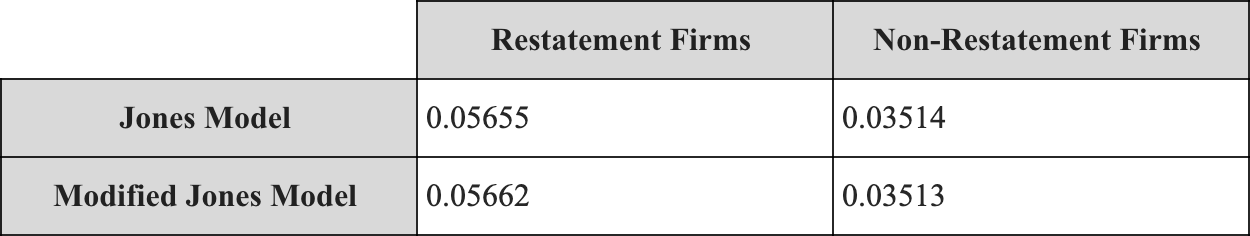

## **Part2: In addition to abnormal accruals, identify other factors that predict whether or not a restatement was due to fraud**

In [44]:
res.corr()

,gvkey,ppe,ppent,revt,delta_rec,delta_rev,delta_rev_rec,Accrual_component,res_cler_err,res_accounting,res_fraud,ipo_amt,count_weak
gvkey,1.000000,0.059925,-0.019016,-0.141249,0.062606,0.072828,0.060270,-0.049087,0.021123,-0.022012,-0.016437,0.010862,0.097829
ppe,0.059925,1.000000,0.339450,-0.004683,0.134748,0.209834,0.192795,0.030973,0.004048,0.003255,-0.021818,0.055368,-0.056095
ppent,-0.019016,0.339450,1.000000,0.047084,-0.011916,0.020367,0.026681,0.042362,-0.032375,0.046516,-0.055461,-0.031199,-0.111194
revt,-0.141249,-0.004683,0.047084,1.000000,0.000956,-0.003299,-0.002431,0.048899,-0.015087,0.004326,0.022859,-0.039101,-0.111778
delta_rec,0.062606,0.134748,-0.011916,0.000956,1.000000,0.494436,0.255527,0.059305,-0.008908,-0.003377,0.010267,0.063026,-0.033131
delta_rev,0.072828,0.209834,0.020367,-0.003299,0.494436,1.000000,0.949987,0.011359,0.064336,-0.062446,-0.006916,0.090180,-0.015320
delta_rev_rec,0.060270,0.192795,0.026681,-0.002431,0.255527,0.949987,1.000000,-0.009645,0.082973,-0.075722,-0.011828,0.083837,-0.016010
Accrual_component,-0.049087,0.030973,0.042362,0.048899,0.059305,0.011359,-0.009645,1.000000,0.042434,-0.041684,0.018721,0.036245,-0.152266
res_cler_err,0.021123,0.004048,-0.032375,-0.015087,-0.008908,0.064336,0.082973,0.042434,1.000000,-0.790437,-0.022396,-0.015343,0.011064
res_accounting,-0.022012,0.003255,0.046516,0.004326,-0.003377,-0.062446,-0.075722,-0.041684,-0.790437,1.000000,-0.466715,0.023163,-0.047694


In [0]:
# remove variables with colinearity
res2=res[['ppe', 'delta_rec', 'delta_rev', 'Accrual_component', 'res_accounting', 
       'res_fraud', 'ipo_amt', 'count_weak']]

In [46]:
#Actual
res2['res_fraud'].value_counts()

0.0    1931
1.0      33
Name: res_fraud, dtype: int64

#### **Implement logistic regression model on restatement data**
#### **Target variable: Restate due to fraud 1/0 (*res_fraud*)**
#### **Predictors: Change in receivables (*delta_rec*), change in PPE (*ppe*), change in revenue (*delta_rev*), change in accruals (*Accrual_component*), ipo 1/0 (*ipo_amt*), count_weak and restate due to accounting error (*res_accounting*)**

In [0]:
y = res2[['res_fraud']]
x = res2.drop(['res_fraud'],axis=1)

In [48]:
x['ipo_amt'].value_counts()

0.0    1897
1.0      67
Name: ipo_amt, dtype: int64

In [49]:
import statsmodels.api as sm
from scipy import stats

x2 = sm.add_constant(x) 
model = sm.Logit(y,x2)

result = model.fit()
print(result.summary())

         Current function value: 0.048090
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              res_fraud   No. Observations:                 1964
Model:                          Logit   Df Residuals:                     1956
Method:                           MLE   Df Model:                            7
Date:                Wed, 25 Mar 2020   Pseudo R-squ.:                  0.4364
Time:                        02:16:13   Log-Likelihood:                -94.448
converged:                      False   LL-Null:                       -167.57
Covariance Type:            nonrobust   LLR p-value:                 2.503e-28
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9975      1.785     -0.559      0.576      -4.495       2.500
ppe                  -1.1485      1.900     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### **The predictors change in receivable, change in revenue, res_accounting and count_weak have p-values less than 0.05 and are therefore statistically significant. We can say with 95% confidence that these predictors are useful in predicting restatement caused by fraud.** 

## **Part3: Train the above model with 2016 and 2017 data to predict the 100 most likely firms to commit fraud and restate earnings in the following year, and verify the prediction with 2018 data**

In [0]:
## Retrieve year 2016 and 2017 data to train the model again
funda = conn.raw_sql("""
                      select *
	                  from compa.funda where (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and 
	                     fyear>2015 and
                       fyear<2018
                      """) 

In [51]:
funda=funda[['gvkey', 'fyear', 'act', 'oiadp', 'at', 'che', 'lct', 'dlc', 'txp', 'dp', 'exchg', 'datadate','tic','cik','ppent','revt', 'rect']]
funda=funda.rename(columns={'cik':'company_fkey','datadate':'matchfy_date_qtr'})
funda.head()

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect
0,001004,2016.0,888.500,77.200,1504.100,10.300,335.100,2.000,12.300,71.000,11.0,2017-05-31,AIR,0000001750,361.50,1767.600,251.400
1,001119,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2016-12-31,ADX,0000002230,NaN,NaN,NaN
2,001352,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,2016-12-31,GYLD,None,NaN,NaN,NaN
3,001045,2016.0,10324.000,6007.000,51274.000,6997.000,13872.000,1855.000,0.000,1826.000,14.0,2016-12-31,AAL,0000006201,31159.00,40180.000,1594.000
4,001050,2016.0,212.978,37.316,498.634,47.322,146.358,14.597,1.536,18.903,14.0,2016-12-31,CECE,0000003197,27.27,417.011,83.062


In [52]:
# lag1 variables
funda1=funda[['gvkey', 'fyear', 'act', 'at', 'che', 'lct', 'dlc', 'txp','revt','rect','ppent']].copy()
funda1['fyear']=funda1['fyear']+1 
funda1=funda1.rename(columns={'at':'at_lag1', 'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1','txp':'txp_lag1','revt':'revt_lag1','rect':'rect_lag1','ppent':'ppent_lag1'})
funda1=pd.merge(funda,funda1,how='left',on=['gvkey','fyear'])
funda1=funda1.dropna()
funda1

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1
11197,001004,2017.0,942.700,86.000,1524.700,41.600,333.300,0.000,0.000,40.500,11.0,2018-05-31,AIR,0000001750,316.600,1748.300,203.000,888.500,1504.100,10.300,335.100,2.000,12.300,1767.600,251.400,361.500
11199,001045,2017.0,9146.000,4792.000,51396.000,5384.000,14964.000,2554.000,0.000,2017.000,14.0,2017-12-31,AAL,0000006201,34156.000,42207.000,1752.000,10324.000,51274.000,6997.000,13872.000,1855.000,0.000,40180.000,1594.000,31159.000
11200,001050,2017.0,173.942,11.977,438.549,30.493,107.851,17.097,0.000,16.088,14.0,2017-12-31,CECE,0000003197,23.400,345.051,67.990,212.978,498.634,47.322,146.358,14.597,1.536,417.011,83.062,27.270
11203,001072,2017.0,1701.724,182.534,2672.766,827.202,294.563,0.000,8.290,59.819,11.0,2018-03-31,AVX,0000859163,418.286,1562.474,287.080,1836.404,2477.413,1107.382,216.067,0.000,3.944,1312.661,221.091,239.951
11204,001075,2017.0,1016.288,934.427,17019.082,13.892,1197.852,177.400,148.946,534.118,11.0,2017-12-31,PNW,0000764622,13188.077,3565.296,415.068,822.219,16004.253,8.881,1292.946,302.200,138.964,3498.682,355.403,12624.254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22096,318815,2017.0,25.141,-21.751,66.595,17.864,11.314,0.488,0.000,3.463,14.0,2017-12-31,MTP,0001643918,3.421,10.279,5.156,27.515,69.937,21.723,11.529,0.664,0.000,8.541,4.061,3.412
22101,324684,2017.0,50.645,-39.139,51.334,50.573,5.979,0.000,0.000,0.210,14.0,2017-12-31,ASLN,0001722926,0.444,0.000,0.000,53.121,53.714,51.737,3.804,0.000,0.000,11.547,1.294,0.384
22103,326688,2017.0,732.600,362.800,4725.000,26.900,390.900,0.000,41.800,97.900,11.0,2017-12-31,NVT,0001720635,265.800,2097.900,349.300,657.300,4493.800,21.500,318.400,0.000,20.900,2116.000,314.800,260.200
22104,327451,2017.0,187.202,-8.145,507.122,46.522,163.249,91.992,3.551,19.680,14.0,2017-12-31,GRIN,0001725293,238.592,409.522,26.527,160.823,590.154,67.711,141.659,71.390,3.842,371.532,77.572,303.897


In [54]:
# Earnings  = Income from Continuing Operations(OIADP) / Average Total Assets
# Average Total Assets = (ATt + ATt-1) / 2
funda1['Avg_Total_Asset']=(funda1['at']+funda1['at_lag1'])/2
funda1['Earning']=funda1['oiadp']/funda1['Avg_Total_Asset']
funda1

# Accrual Component = Accruals / Average Total Assets
# Accruals = (delta(CA)-delta(Cash)) - (delta(CL)-delta(STD)-delta(TP)) - Dep
funda1['CA']=funda1['act']-funda1['act_lag1']
funda1['Cash']=funda1['che']-funda1['che_lag1']
funda1['CL']=funda1['lct']-funda1['lct_lag1']
funda1['STD']=funda1['dlc']-funda1['dlc_lag1']
funda1['TP']=(funda1['txp']+funda1['txp_lag1'])/2
funda1['Accruals']=(funda1['CA']-funda1['Cash'])-(funda1['CL']-funda1['STD']-funda1['TP'])-funda1['dp']
funda1['Accrual_component']=funda1['Accruals']/funda1['Avg_Total_Asset']
funda1

# Cash Flow Component = Earnings - Accrual Component
funda1['CF_component']=funda1['Earning']-funda1['Accrual_component']

# delta(revenue)
funda1['delta_rev']=(funda1['revt']-funda1['revt_lag1'])/funda1['Avg_Total_Asset']
# delta(receivable)
funda1['delta_rec']=(funda1['rect']-funda1['rect_lag1'])/funda1['Avg_Total_Asset']
# delta(revenue) - delta(receivable)
funda1['delta_rev_rec'] = funda1['delta_rev'] - funda1['delta_rec']
# ppe adjust for firm size
funda1['ppent'] = funda1['ppent'] / funda1['Avg_Total_Asset']

## delta_ppe
funda1['ppe'] = (funda1['ppent'] - funda1['ppent_lag1'])/funda1['Avg_Total_Asset']

funda=funda1.dropna()
funda

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,delta_rev,delta_rec,delta_rev_rec,ppe
11197,001004,2017.0,942.700,86.000,1524.700,41.600,333.300,0.000,0.000,40.500,11.0,2018-05-31,AIR,0000001750,0.000138,1748.300,203.000,888.500,1504.100,10.300,335.100,2.000,12.300,1767.600,251.400,361.500,1514.4000,0.056788,54.200,31.300,-1.800,-2.000,6.1500,-11.6500,-0.007693,0.064481,-0.012744,-0.031960,0.019216,-0.238708
11199,001045,2017.0,9146.000,4792.000,51396.000,5384.000,14964.000,2554.000,0.000,2017.000,14.0,2017-12-31,AAL,0000006201,0.000013,42207.000,1752.000,10324.000,51274.000,6997.000,13872.000,1855.000,0.000,40180.000,1594.000,31159.000,51335.0000,0.093348,-1178.000,-1613.000,1092.000,699.000,0.0000,-1975.0000,-0.038473,0.131820,0.039486,0.003078,0.036408,-0.606974
11200,001050,2017.0,173.942,11.977,438.549,30.493,107.851,17.097,0.000,16.088,14.0,2017-12-31,CECE,0000003197,0.000107,345.051,67.990,212.978,498.634,47.322,146.358,14.597,1.536,417.011,83.062,27.270,468.5915,0.025560,-39.036,-16.829,-38.507,2.500,0.7680,3.4800,0.007427,0.018133,-0.153567,-0.032164,-0.121402,-0.058195
11203,001072,2017.0,1701.724,182.534,2672.766,827.202,294.563,0.000,8.290,59.819,11.0,2018-03-31,AVX,0000859163,0.000063,1562.474,287.080,1836.404,2477.413,1107.382,216.067,0.000,3.944,1312.661,221.091,239.951,2575.0895,0.070885,-134.680,-280.180,78.496,0.000,6.1170,13.3020,0.005166,0.065719,0.097011,0.025626,0.071385,-0.093182
11204,001075,2017.0,1016.288,934.427,17019.082,13.892,1197.852,177.400,148.946,534.118,11.0,2017-12-31,PNW,0000764622,0.000048,3565.296,415.068,822.219,16004.253,8.881,1292.946,302.200,138.964,3498.682,355.403,12624.254,16511.6675,0.056592,194.069,5.011,-95.094,-124.800,143.9550,-230.8110,-0.013979,0.070571,0.004034,0.003614,0.000421,-0.764566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22096,318815,2017.0,25.141,-21.751,66.595,17.864,11.314,0.488,0.000,3.463,14.0,2017-12-31,MTP,0001643918,0.000734,10.279,5.156,27.515,69.937,21.723,11.529,0.664,0.000,8.541,4.061,3.412,68.2660,-0.318621,-2.374,-3.859,-0.215,-0.176,0.0000,-1.9390,-0.028404,-0.290218,0.025459,0.016040,0.009419,-0.049970
22101,324684,2017.0,50.645,-39.139,51.334,50.573,5.979,0.000,0.000,0.210,14.0,2017-12-31,ASLN,0001722926,0.000161,0.000,0.000,53.121,53.714,51.737,3.804,0.000,0.000,11.547,1.294,0.384,52.5240,-0.745164,-2.476,-1.164,2.175,0.000,0.0000,-3.6970,-0.070387,-0.674777,-0.219842,-0.024636,-0.195206,-0.007308
22103,326688,2017.0,732.600,362.800,4725.000,26.900,390.900,0.000,41.800,97.900,11.0,2017-12-31,NVT,0001720635,0.000013,2097.900,349.300,657.300,4493.800,21.500,318.400,0.000,20.900,2116.000,314.800,260.200,4609.4000,0.078709,75.300,5.400,72.500,0.000,31.3500,-69.1500,-0.015002,0.093711,-0.003927,0.007485,-0.011411,-0.056450
22104,327451,2017.0,187.202,-8.145,507.122,46.522,163.249,91.992,3.551,19.680,14.0,2017-12-31,GRIN,0001725293,0.000793,409.522,26.527,160.823,590.154,67.711,141.659,71.390,3.842,371.532,77.572,303.897,548.6380,-0.014846,26.379,-21.189,21.590,20.602,3.6965,30.5965,0.055768,-0.070614,0.069244,-0.093039,0.162284,-0.553910


In [55]:
funda.columns

Index(['gvkey', 'fyear', 'act', 'oiadp', 'at', 'che', 'lct', 'dlc', 'txp',
       'dp', 'exchg', 'matchfy_date_qtr', 'tic', 'company_fkey', 'ppent',
       'revt', 'rect', 'act_lag1', 'at_lag1', 'che_lag1', 'lct_lag1',
       'dlc_lag1', 'txp_lag1', 'revt_lag1', 'rect_lag1', 'ppent_lag1',
       'Avg_Total_Asset', 'Earning', 'CA', 'Cash', 'CL', 'STD', 'TP',
       'Accruals', 'Accrual_component', 'CF_component', 'delta_rev',
       'delta_rec', 'delta_rev_rec', 'ppe'],
      dtype='object')

In [56]:
## funda winsorization
varlist=['act', 'oiadp', 'at', 'che', 'lct', 'dlc', 'txp',
       'dp', 'exchg', 'ppe', 'revt', 'rect',  'act_lag1', 'at_lag1',
       'che_lag1', 'lct_lag1', 'dlc_lag1', 'txp_lag1', 'revt_lag1',
       'rect_lag1', 'Avg_Total_Asset', 'Earning', 'CA', 'Cash', 'CL', 'STD',
       'TP', 'Accruals', 'Accrual_component', 'CF_component', 'delta_rev',
       'delta_rec', 'delta_rev_rec', ]
for var in varlist:
    funda[var] = funda[var].replace(np.Inf, np.nan)
    funda[var]=np.where(funda[var].isnull(), np.nan, winsorize(funda[var], limits=(0.01,0.01)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [57]:
icd = conn.raw_sql("""
                      select company_fkey,matchfy_date_qtr, count_weak
	                  from audit.auditsox404 
                      """) 
icd.head()

,company_fkey,matchfy_date_qtr,count_weak
0,0000000020,2006-12-30,0.0
1,0000000020,2006-12-30,0.0
2,0000000020,2007-12-29,0.0
3,0000000020,2007-12-29,0.0
4,0000016873,2008-12-28,0.0


In [58]:
icd['count_weak'].value_counts()

0.0     146267
1.0      10665
2.0       6698
3.0       4891
4.0       2218
5.0        907
6.0        408
7.0        226
8.0        118
9.0         90
10.0        62
11.0        42
13.0        24
12.0        18
17.0        15
15.0        15
14.0        13
20.0        13
16.0        10
19.0         5
18.0         5
33.0         4
25.0         3
38.0         2
26.0         2
24.0         1
21.0         1
Name: count_weak, dtype: int64

In [59]:
## left join above data with internal control deficiency
with_audit_icd=pd.merge(audit,icd,how='left',on=['company_fkey','matchfy_date_qtr'])
with_audit_icd=with_audit_icd.drop_duplicates()
with_audit_icd

,company_fkey,matchfy_date_qtr,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,count_weak
0,0000001750,2016-05-31,2015-05-31,0.0,1.0,0.0,AIR,0.0
2,0000001853,2006-12-28,2005-12-31,0.0,1.0,0.0,None,NaN
3,0000001853,2007-12-28,2006-12-28,0.0,1.0,0.0,None,NaN
4,0000001923,2009-04-30,2008-04-30,0.0,1.0,0.0,None,0.0
5,0000002034,None,2018-06-30,0.0,1.0,0.0,None,NaN
...,...,...,...,...,...,...,...,...
25350,0001764046,None,None,0.0,1.0,0.0,None,NaN
25351,0001766352,2019-09-30,2018-09-30,0.0,1.0,0.0,None,NaN
25353,0001771910,None,2018-12-31,0.0,1.0,0.0,None,NaN
25354,0001778630,None,None,0.0,1.0,0.0,None,NaN


In [0]:
#null_weakness=res.loc[res['count_weak'].isna()]
#no_weakness=res.loc[res['count_weak']==0]
#null_weakness['res_fraud'].value_counts(), no_weakness['res_fraud'].value_counts()

In [61]:
## left join above data with audit --> all firms regardless of restatement
all_data=pd.merge(funda,with_audit_icd,how='left',on=['company_fkey','matchfy_date_qtr'])
all_data=all_data.drop_duplicates()
all_data[['count_weak']]=all_data[['count_weak']].fillna(0)
all_data

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,delta_rev,delta_rec,delta_rev_rec,ppe,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,count_weak
0,001004,2017.0,942.700,86.000,1524.700,41.600,333.300,0.000,0.000,40.500,11.0,2018-05-31,AIR,0000001750,0.000138,1748.300,203.000,888.500,1504.100,10.300,335.100,2.000,12.300,1767.600,251.400,361.500,1514.4000,0.056788,54.200,31.300,-1.800,-2.000,6.1500,-11.6500,-0.007693,0.064481,-0.012744,-0.031960,0.019216,-0.238708,NaN,NaN,NaN,NaN,NaN,0.0
1,001045,2017.0,9146.000,4792.000,51396.000,5384.000,14964.000,2554.000,0.000,2017.000,14.0,2017-12-31,AAL,0000006201,0.000013,42207.000,1752.000,10324.000,51274.000,6997.000,13872.000,1855.000,0.000,40180.000,1594.000,31159.000,51335.0000,0.093348,-1178.000,-1243.000,1092.000,699.000,0.0000,-1975.0000,-0.038473,0.131820,0.039486,0.003078,0.036408,-0.606974,NaN,NaN,NaN,NaN,NaN,0.0
2,001050,2017.0,173.942,11.977,438.549,30.493,107.851,17.097,0.000,16.088,14.0,2017-12-31,CECE,0000003197,0.000107,345.051,67.990,212.978,498.634,47.322,146.358,14.597,1.536,417.011,83.062,27.270,468.5915,0.025560,-39.036,-16.829,-38.507,2.500,0.7680,3.4800,0.007427,0.018133,-0.153567,-0.032164,-0.121402,-0.058195,NaN,NaN,NaN,NaN,NaN,0.0
3,001072,2017.0,1701.724,182.534,2672.766,827.202,294.563,0.000,8.290,59.819,11.0,2018-03-31,AVX,0000859163,0.000063,1562.474,287.080,1836.404,2477.413,1107.382,216.067,0.000,3.944,1312.661,221.091,239.951,2575.0895,0.070885,-134.680,-280.180,78.496,0.000,6.1170,13.3020,0.005166,0.065719,0.097011,0.025626,0.071385,-0.093182,NaN,NaN,NaN,NaN,NaN,0.0
4,001075,2017.0,1016.288,934.427,17019.082,13.892,1197.852,177.400,148.946,534.118,11.0,2017-12-31,PNW,0000764622,0.000048,3565.296,415.068,822.219,16004.253,8.881,1292.946,302.200,138.964,3498.682,355.403,12624.254,16511.6675,0.056592,194.069,5.011,-95.094,-124.800,143.9550,-230.8110,-0.013979,0.070571,0.004034,0.003614,0.000421,-0.764566,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314,318815,2017.0,25.141,-21.751,66.595,17.864,11.314,0.488,0.000,3.463,14.0,2017-12-31,MTP,0001643918,0.000734,10.279,5.156,27.515,69.937,21.723,11.529,0.664,0.000,8.541,4.061,3.412,68.2660,-0.318621,-2.374,-3.859,-0.215,-0.176,0.0000,-1.9390,-0.028404,-0.290218,0.025459,0.016040,0.009419,-0.049970,NaN,NaN,NaN,NaN,NaN,0.0
5315,324684,2017.0,50.645,-39.139,51.334,50.573,5.979,0.000,0.000,0.210,14.0,2017-12-31,ASLN,0001722926,0.000161,0.000,0.000,53.121,53.714,51.737,3.804,0.000,0.000,11.547,1.294,0.384,52.5240,-0.745164,-2.476,-1.164,2.175,0.000,0.0000,-3.6970,-0.070387,-0.674777,-0.219842,-0.024636,-0.195206,-0.007308,NaN,NaN,NaN,NaN,NaN,0.0
5316,326688,2017.0,732.600,362.800,4725.000,26.900,390.900,0.000,41.800,97.900,11.0,2017-12-31,NVT,0001720635,0.000013,2097.900,349.300,657.300,4493.800,21.500,318.400,0.000,20.900,2116.000,314.800,260.200,4609.4000,0.078709,75.300,5.400,72.500,0.000,31.3500,-69.1500,-0.015002,0.093711,-0.003927,0.007485,-0.011411,-0.056450,NaN,NaN,NaN,NaN,NaN,0.0
5317,327451,2017.0,187.202,-8.145,507.122,46.522,163.249,91.992,3.551,19.680,14.0,2017-12-31,GRIN,0001725293,0.000793,409.522,26.527,160.823,590.154,67.711,141.659,71.390,3.842,371.532,77.572,303.897,548.6380,-0.014846,26.379,-21.189,21.590,20.602,3.6965,30.5965,0.055768,-0.070614,0.069244,-0.093039,0.162284,-0.553910,NaN,NaN,NaN,NaN,NaN,0.0


In [62]:
all_data.describe().columns

Index(['fyear', 'act', 'oiadp', 'at', 'che', 'lct', 'dlc', 'txp', 'dp',
       'exchg', 'ppent', 'revt', 'rect', 'act_lag1', 'at_lag1', 'che_lag1',
       'lct_lag1', 'dlc_lag1', 'txp_lag1', 'revt_lag1', 'rect_lag1',
       'ppent_lag1', 'Avg_Total_Asset', 'Earning', 'CA', 'Cash', 'CL', 'STD',
       'TP', 'Accruals', 'Accrual_component', 'CF_component', 'delta_rev',
       'delta_rec', 'delta_rev_rec', 'ppe', 'res_cler_err', 'res_accounting',
       'res_fraud', 'count_weak'],
      dtype='object')

In [0]:
## Min-max normalize before splitting 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(all_data[['ppe','ppent', 'revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud',  'count_weak']])
all_data[['ppe', 'ppent','revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud', 'count_weak']]=scaler.transform(all_data[['ppe', 'ppent','revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud', 'count_weak']])

In [64]:
all_data

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,delta_rev,delta_rec,delta_rev_rec,ppe,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,count_weak
0,001004,2017.0,942.700,86.000,1524.700,41.600,333.300,0.000,0.000,40.500,11.0,2018-05-31,AIR,0000001750,3.451197e-06,0.026539,203.000,888.500,1504.100,10.300,335.100,2.000,12.300,1767.600,251.400,361.500,1514.4000,0.056788,54.200,31.300,-1.800,-2.000,6.1500,-11.6500,0.767963,0.064481,0.389042,0.309661,0.443635,0.396333,NaN,NaN,NaN,NaN,NaN,0.0
1,001045,2017.0,9146.000,4792.000,51396.000,5384.000,14964.000,2554.000,0.000,2017.000,14.0,2017-12-31,AAL,0000006201,3.240260e-07,0.640691,1752.000,10324.000,51274.000,6997.000,13872.000,1855.000,0.000,40180.000,1594.000,31159.000,51335.0000,0.093348,-1178.000,-1243.000,1092.000,699.000,0.0000,-1975.0000,0.761940,0.131820,0.413028,0.372322,0.451681,0.205039,NaN,NaN,NaN,NaN,NaN,0.0
2,001050,2017.0,173.942,11.977,438.549,30.493,107.851,17.097,0.000,16.088,14.0,2017-12-31,CECE,0000003197,2.664201e-06,0.005238,67.990,212.978,498.634,47.322,146.358,14.597,1.536,417.011,83.062,27.270,468.5915,0.025560,-39.036,-16.829,-38.507,2.500,0.7680,3.4800,0.770921,0.018133,0.324372,0.309295,0.377824,0.490099,NaN,NaN,NaN,NaN,NaN,0.0
3,001072,2017.0,1701.724,182.534,2672.766,827.202,294.563,0.000,8.290,59.819,11.0,2018-03-31,AVX,0000859163,1.576989e-06,0.023718,287.080,1836.404,2477.413,1107.382,216.067,0.000,3.944,1312.661,221.091,239.951,2575.0895,0.070885,-134.680,-280.180,78.496,0.000,6.1170,13.3020,0.770479,0.065719,0.439446,0.412647,0.468051,0.471926,NaN,NaN,NaN,NaN,NaN,0.0
4,001075,2017.0,1016.288,934.427,17019.082,13.892,1197.852,177.400,148.946,534.118,11.0,2017-12-31,PNW,0000764622,1.209315e-06,0.054120,415.068,822.219,16004.253,8.881,1292.946,302.200,138.964,3498.682,355.403,12624.254,16511.6675,0.056592,194.069,5.011,-95.094,-124.800,143.9550,-230.8110,0.766733,0.070571,0.396747,0.373280,0.434839,0.123178,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314,318815,2017.0,25.141,-21.751,66.595,17.864,11.314,0.488,0.000,3.463,14.0,2017-12-31,MTP,0001643918,1.835203e-05,0.000156,5.156,27.515,69.937,21.723,11.529,0.664,0.000,8.541,4.061,3.412,68.2660,-0.318621,-2.374,-3.859,-0.215,-0.176,0.0000,-1.9390,0.763911,-0.290218,0.406586,0.395504,0.439050,0.494372,NaN,NaN,NaN,NaN,NaN,0.0
5315,324684,2017.0,50.645,-39.139,51.334,50.573,5.979,0.000,0.000,0.210,14.0,2017-12-31,ASLN,0001722926,4.023531e-06,0.000000,0.000,53.121,53.714,51.737,3.804,0.000,0.000,11.547,1.294,0.384,52.5240,-0.745164,-2.476,-1.164,2.175,0.000,0.0000,-3.6970,0.755696,-0.674777,0.293935,0.322758,0.343283,0.516533,NaN,NaN,NaN,NaN,NaN,0.0
5316,326688,2017.0,732.600,362.800,4725.000,26.900,390.900,0.000,41.800,97.900,11.0,2017-12-31,NVT,0001720635,3.127564e-07,0.031846,349.300,657.300,4493.800,21.500,318.400,0.000,20.900,2116.000,314.800,260.200,4609.4000,0.078709,75.300,5.400,72.500,0.000,31.3500,-69.1500,0.766533,0.093711,0.393091,0.380203,0.429301,0.491006,NaN,NaN,NaN,NaN,NaN,0.0
5317,327451,2017.0,187.202,-8.145,507.122,46.522,163.249,91.992,3.551,19.680,14.0,2017-12-31,GRIN,0001725293,1.981637e-05,0.006216,26.527,160.823,590.154,67.711,141.659,71.390,3.842,371.532,77.572,303.897,548.6380,-0.014846,26.379,-21.189,21.590,20.602,3.6965,30.5965,0.780380,-0.070614,0.426694,0.200426,0.510592,0.232602,NaN,NaN,NaN,NaN,NaN,0.0


In [65]:
## restatement value check
all_data['res_cler_err'].value_counts(), all_data['res_accounting'].value_counts(), all_data['res_fraud'].value_counts()

(0.0    245
 1.0      1
 Name: res_cler_err, dtype: int64, 1.0    244
 0.0      2
 Name: res_accounting, dtype: int64, 0.0    242
 1.0      4
 Name: res_fraud, dtype: int64)

In [66]:
## firms without restatement
non_res_data=all_data.loc[(all_data['res_cler_err'].isna()) & (all_data['res_accounting'].isna()) & (all_data['res_fraud'].isna())]
non_res_data

,gvkey,fyear,act,oiadp,at,che,lct,dlc,txp,dp,exchg,matchfy_date_qtr,tic,company_fkey,ppent,revt,rect,act_lag1,at_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,revt_lag1,rect_lag1,ppent_lag1,Avg_Total_Asset,Earning,CA,Cash,CL,STD,TP,Accruals,Accrual_component,CF_component,delta_rev,delta_rec,delta_rev_rec,ppe,priorfy_date_qtr,res_cler_err,res_accounting,res_fraud,best_edgar_ticker,count_weak
0,001004,2017.0,942.700,86.000,1524.700,41.600,333.300,0.000,0.000,40.500,11.0,2018-05-31,AIR,0000001750,3.451197e-06,0.026539,203.000,888.500,1504.100,10.300,335.100,2.000,12.300,1767.600,251.400,361.500,1514.4000,0.056788,54.200,31.300,-1.800,-2.000,6.1500,-11.6500,0.767963,0.064481,0.389042,0.309661,0.443635,0.396333,NaN,NaN,NaN,NaN,NaN,0.0
1,001045,2017.0,9146.000,4792.000,51396.000,5384.000,14964.000,2554.000,0.000,2017.000,14.0,2017-12-31,AAL,0000006201,3.240260e-07,0.640691,1752.000,10324.000,51274.000,6997.000,13872.000,1855.000,0.000,40180.000,1594.000,31159.000,51335.0000,0.093348,-1178.000,-1243.000,1092.000,699.000,0.0000,-1975.0000,0.761940,0.131820,0.413028,0.372322,0.451681,0.205039,NaN,NaN,NaN,NaN,NaN,0.0
2,001050,2017.0,173.942,11.977,438.549,30.493,107.851,17.097,0.000,16.088,14.0,2017-12-31,CECE,0000003197,2.664201e-06,0.005238,67.990,212.978,498.634,47.322,146.358,14.597,1.536,417.011,83.062,27.270,468.5915,0.025560,-39.036,-16.829,-38.507,2.500,0.7680,3.4800,0.770921,0.018133,0.324372,0.309295,0.377824,0.490099,NaN,NaN,NaN,NaN,NaN,0.0
3,001072,2017.0,1701.724,182.534,2672.766,827.202,294.563,0.000,8.290,59.819,11.0,2018-03-31,AVX,0000859163,1.576989e-06,0.023718,287.080,1836.404,2477.413,1107.382,216.067,0.000,3.944,1312.661,221.091,239.951,2575.0895,0.070885,-134.680,-280.180,78.496,0.000,6.1170,13.3020,0.770479,0.065719,0.439446,0.412647,0.468051,0.471926,NaN,NaN,NaN,NaN,NaN,0.0
4,001075,2017.0,1016.288,934.427,17019.082,13.892,1197.852,177.400,148.946,534.118,11.0,2017-12-31,PNW,0000764622,1.209315e-06,0.054120,415.068,822.219,16004.253,8.881,1292.946,302.200,138.964,3498.682,355.403,12624.254,16511.6675,0.056592,194.069,5.011,-95.094,-124.800,143.9550,-230.8110,0.766733,0.070571,0.396747,0.373280,0.434839,0.123178,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314,318815,2017.0,25.141,-21.751,66.595,17.864,11.314,0.488,0.000,3.463,14.0,2017-12-31,MTP,0001643918,1.835203e-05,0.000156,5.156,27.515,69.937,21.723,11.529,0.664,0.000,8.541,4.061,3.412,68.2660,-0.318621,-2.374,-3.859,-0.215,-0.176,0.0000,-1.9390,0.763911,-0.290218,0.406586,0.395504,0.439050,0.494372,NaN,NaN,NaN,NaN,NaN,0.0
5315,324684,2017.0,50.645,-39.139,51.334,50.573,5.979,0.000,0.000,0.210,14.0,2017-12-31,ASLN,0001722926,4.023531e-06,0.000000,0.000,53.121,53.714,51.737,3.804,0.000,0.000,11.547,1.294,0.384,52.5240,-0.745164,-2.476,-1.164,2.175,0.000,0.0000,-3.6970,0.755696,-0.674777,0.293935,0.322758,0.343283,0.516533,NaN,NaN,NaN,NaN,NaN,0.0
5316,326688,2017.0,732.600,362.800,4725.000,26.900,390.900,0.000,41.800,97.900,11.0,2017-12-31,NVT,0001720635,3.127564e-07,0.031846,349.300,657.300,4493.800,21.500,318.400,0.000,20.900,2116.000,314.800,260.200,4609.4000,0.078709,75.300,5.400,72.500,0.000,31.3500,-69.1500,0.766533,0.093711,0.393091,0.380203,0.429301,0.491006,NaN,NaN,NaN,NaN,NaN,0.0
5317,327451,2017.0,187.202,-8.145,507.122,46.522,163.249,91.992,3.551,19.680,14.0,2017-12-31,GRIN,0001725293,1.981637e-05,0.006216,26.527,160.823,590.154,67.711,141.659,71.390,3.842,371.532,77.572,303.897,548.6380,-0.014846,26.379,-21.189,21.590,20.602,3.6965,30.5965,0.780380,-0.070614,0.426694,0.200426,0.510592,0.232602,NaN,NaN,NaN,NaN,NaN,0.0


In [0]:
## firms with restatement
res_data = all_data.drop(non_res_data.index)

In [0]:
# column selection
non_res_data=non_res_data[['Accrual_component','ppent','revt','delta_rev','delta_rev_rec']]
res_data=res_data[[ 'matchfy_date_qtr','gvkey', 'ppe','ppent', 'revt', 'delta_rec','delta_rev', 'delta_rev_rec', 'Accrual_component', 'res_cler_err', 'res_accounting', 'res_fraud','count_weak']]

In [69]:
non_res_data.head(), res_data

(   Accrual_component         ppent      revt  delta_rev  delta_rev_rec
 0           0.767963  3.451197e-06  0.026539   0.389042       0.443635
 1           0.761940  3.240260e-07  0.640691   0.413028       0.451681
 2           0.770921  2.664201e-06  0.005238   0.324372       0.377824
 3           0.770479  1.576989e-06  0.023718   0.439446       0.468051
 4           0.766733  1.209315e-06  0.054120   0.396747       0.434839,
      matchfy_date_qtr   gvkey       ppe  ...  res_accounting  res_fraud  count_weak
 16         2018-03-31  001210  0.486307  ...             1.0        0.0    0.000000
 21         2017-12-31  001254  0.289009  ...             1.0        0.0    0.000000
 32         2017-12-31  001585  0.466213  ...             1.0        0.0    0.000000
 41         2017-12-31  001678  0.079277  ...             1.0        0.0    0.000000
 46         2017-12-31  001712  0.284525  ...             1.0        0.0    0.000000
 ...               ...     ...       ...  ...            

In [0]:
res_data.to_csv('res_firm.csv',index=False)
non_res_data.to_csv('nonres_firm.csv',index=False)

In [0]:
res=pd.read_csv('res_firm.csv')
nonres=pd.read_csv('nonres_firm.csv')

In [72]:
res.info(), res.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 13 columns):
matchfy_date_qtr     246 non-null object
gvkey                246 non-null int64
ppe                  246 non-null float64
ppent                246 non-null float64
revt                 246 non-null float64
delta_rec            246 non-null float64
delta_rev            246 non-null float64
delta_rev_rec        246 non-null float64
Accrual_component    246 non-null float64
res_cler_err         246 non-null float64
res_accounting       246 non-null float64
res_fraud            246 non-null float64
count_weak           246 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 25.1+ KB


(None,                gvkey         ppe  ...   res_fraud  count_weak
 count     246.000000  246.000000  ...  246.000000  246.000000
 mean    85856.280488    0.398875  ...    0.016260    0.067910
 std     78981.608128    0.163864  ...    0.126732    0.127340
 min      1210.000000    0.015845  ...    0.000000    0.000000
 25%     20521.500000    0.312725  ...    0.000000    0.000000
 50%     32424.500000    0.440136  ...    0.000000    0.000000
 75%    165898.750000    0.499463  ...    0.000000    0.117647
 max    315318.000000    1.000000  ...    1.000000    1.000000
 
 [8 rows x 12 columns])

In [0]:
## Retrieve data about firms that restated in 2018
res2018 = conn.raw_sql("""
                      select *
	                  from compa.funda where (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and 
	                     fyear=2018
                      """) 

In [0]:
res2018=res2018[['cik', 'datadate', 'gvkey']]
res2018=res2018.rename(columns={'cik':'company_fkey','datadate':'matchfy_date_qtr'})

In [0]:
x=res[['delta_rec','delta_rev', 'res_accounting','count_weak']]
y=res['res_fraud']

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(x,y)
prob_y_pred=logreg.predict_proba(x)
prob_y_pred=prob_y_pred[:,1]
prob_y_pred=list(prob_y_pred)
prob_y_pred ## a list of probilities for firms to commit fraud 

[0.015200352596985088,
 0.015127105240685114,
 0.015192378121923119,
 0.015138471061360124,
 0.015166196605641023,
 0.015051232342137752,
 0.015123594104850452,
 0.01580936432897103,
 0.015159606807880479,
 0.015115335439730693,
 0.015125921759861704,
 0.015106697338806426,
 0.015515812168127285,
 0.015138470403964321,
 0.015151627960672091,
 0.01521193581464059,
 0.015142767210693929,
 0.01512359814293938,
 0.015103422361012997,
 0.01527216337756771,
 0.015146081468111186,
 0.015103936444344693,
 0.015143107354309826,
 0.015163949012592617,
 0.015166341303126305,
 0.015181060570835661,
 0.015128730168618933,
 0.015149471865994985,
 0.015130745889532938,
 0.015127059663826404,
 0.015130341165687473,
 0.015130235230586824,
 0.01510287916890975,
 0.01810573837854516,
 0.01586013900293977,
 0.01586374381096493,
 0.01508377330246357,
 0.01513510887780822,
 0.01728797631510539,
 0.015124533025988192,
 0.015139900158479875,
 0.015168197583422896,
 0.015139942922235769,
 0.015186308527422551,

In [77]:
## label firms with unique firm ID - gvkey
labelled = pd.DataFrame(zip(res['gvkey'],prob_y_pred))
labelled.columns = ['gvkey', 'prob']
labelled

,gvkey,prob
0,1210,0.015200
1,1254,0.015127
2,1585,0.015192
3,1678,0.015138
4,1712,0.015166
...,...,...
241,273505,0.015673
242,282553,0.014830
243,285085,0.015072
244,296944,0.015777


In [78]:
## top 100 firms that are most likely to manipulate earnings
l1=labelled.sort_values(by=['prob'],ascending=False)
l1=l1.reset_index().loc[0:99].drop('index',axis=1)
l1

,gvkey,prob
0,26749,0.049722
1,147340,0.045509
2,143710,0.031380
3,23337,0.024709
4,200976,0.023707
...,...,...
95,26367,0.015380
96,62302,0.015353
97,190590,0.015292
98,65399,0.015292


In [79]:
## 2018 restating firms inner join funda to get gvkey
check = pd.merge(res2018,audit,how='inner',on=['company_fkey', 'matchfy_date_qtr'])['gvkey']
check

0      001094
1      001300
2      001920
3      002220
4      002411
        ...  
324    275264
325    287462
326    289735
327    293884
328    316056
Name: gvkey, Length: 329, dtype: object

In [0]:
## data type conversion - object to integer 
a=[]
for i in check:
  a.append(int(i))

In [83]:
## Check if the 100 firms selected above actually restated in 2018
count=0
for i in range(len(l1)):
  while l1['gvkey'][i] in a:
    count += 1
    i += 1
count
accuracy = count / 100
accuracy

0.13

#### **Using the same preprocessing procedure and the selected logistic regression model from Part 2, we predicted the top 100 firms that are most likely to manupulate earnings in 2017. Out of those 100 firms, 13 firms actually restated in 2018. Therefore, we conclude that 13% of our prediction is correct.** 